In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!rm -rf /content/augmentation3_local/

In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/딥러닝분석/original" -d "/content/original"

replace /content/original/original/glioma/Fernando_Feltrin_glioma_100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ───────────────────────────────────────────────────────────────
# 1. 기본 경로 설정
# Colab 기준: '/content/' 폴더 아래에 original/ 폴더가 있다고 가정
base_dir       = '/content'
original_dir   = "/content/original/original"        # 원본 이미지가 클래스별로 들어있는 폴더
split_dir      = os.path.join(base_dir, 'split_data')        # train/val 폴더를 생성할 최상위 디렉토리
train_orig_dir = os.path.join(split_dir, 'train')            # split된 train 원본(70%) 디렉토리
val_orig_dir   = os.path.join(split_dir, 'val')              # split된 val 원본(30%) 디렉토리

aug_local_root = os.path.join(base_dir, 'augmentation3_local')
# → 최종 “원본 train(70%) + 오프라인 증강본(70% × 3)”을 저장할 폴더

# 증강 비율: 원본 1장당 k_per_image개 생성
k_per_image = 3

# ───────────────────────────────────────────────────────────────
# 2. split_data/train, split_data/val 폴더 생성하기 (원본을 70:30으로 나누기)
classes = sorted(os.listdir(original_dir))
# 참고: original/ 하위에 반드시 클래스별 폴더만 있고, 불필요한 파일이 없어야 합니다.

# (1) split_data, train, val 기본 디렉토리 생성
os.makedirs(train_orig_dir, exist_ok=True)
os.makedirs(val_orig_dir, exist_ok=True)

for cls in classes:
    src_cls_folder = os.path.join(original_dir, cls)
    if not os.path.isdir(src_cls_folder):
        continue  # 만약 이미지 파일이 아니라 딴 파일이 섞여 있으면 건너뛰기

    # 클래스별 train/val 디렉토리 경로
    train_cls_folder = os.path.join(train_orig_dir, cls)
    val_cls_folder   = os.path.join(val_orig_dir, cls)
    os.makedirs(train_cls_folder, exist_ok=True)
    os.makedirs(val_cls_folder, exist_ok=True)

    # (2) 클래스별로 파일 목록을 불러와서 shuffle 후 70:30 비율로 나누기
    all_files = [fname for fname in os.listdir(src_cls_folder)
                 if os.path.isfile(os.path.join(src_cls_folder, fname))]
    random.shuffle(all_files)

    n_total = len(all_files)
    n_train = int(n_total * 0.7)   # 70% → train
    # 나머지 30% → val
    train_files = all_files[:n_train]
    val_files   = all_files[n_train:]

    # (3) train_files를 split_data/train/[cls]/ 로 복사
    for fname in train_files:
        src_path = os.path.join(src_cls_folder, fname)
        dst_path = os.path.join(train_cls_folder, fname)
        shutil.copy(src_path, dst_path)

    # (4) val_files를 split_data/val/[cls]/ 로 복사
    for fname in val_files:
        src_path = os.path.join(src_cls_folder, fname)
        dst_path = os.path.join(val_cls_folder, fname)
        shutil.copy(src_path, dst_path)

# ───────────────────────────────────────────────────────────────
# 3. 오프라인 증강을 위해 augmentation3_local 폴더 구조 만들기
#    그리고 train_orig_dir(70% 원본)을 여기에 복사(원본 train 70% 포함),
#    이후 ImageDataGenerator를 통해 증강본을 동일 폴더에 저장

# (1) augmentation3_local 및 클래스별 서브폴더 생성
os.makedirs(aug_local_root, exist_ok=True)
for cls in classes:
    cls_folder = os.path.join(aug_local_root, cls)
    os.makedirs(cls_folder, exist_ok=True)

# (2) 먼저 “원본 train(70%)”을 augmentation3_local/[cls]로 복사
for cls in classes:
    src_train_cls = os.path.join(train_orig_dir, cls)   # split_data/train/[cls]
    dst_aug_cls   = os.path.join(aug_local_root, cls)   # augmentation3_local/[cls]
    if not os.path.isdir(src_train_cls):
        continue
    for fname in os.listdir(src_train_cls):
        src_path = os.path.join(src_train_cls, fname)
        dst_path = os.path.join(dst_aug_cls, fname)
        shutil.copy(src_path, dst_path)

# ───────────────────────────────────────────────────────────────
# 4. ImageDataGenerator 객체 정의 (오프라인 증강용)
datagen = ImageDataGenerator(
    rescale=1./255,        # 필요에 따라 스케일만 해 주거나(단 rescale은 옵션)
    rotation_range=20,     # 회전 범위
    width_shift_range=0.1, # 좌우 이동
    height_shift_range=0.1,# 상하 이동
    shear_range=0.1,       # 전단 변환
    zoom_range=0.1,        # 확대/축소
    horizontal_flip=True,  # 좌우 뒤집기
    fill_mode='nearest'    # 빈 공간을 가장 가까운 픽셀로 채우기
)

# ───────────────────────────────────────────────────────────────
# 5. 오프라인 증강 수행: train_orig_dir → augmentation3_local 에 k_per_image개씩 추가 생성

for cls in classes:
    # (1) flow_from_directory를 위해 ‘클래스 폴더만 읽어오는’ 폴더 설정
    #     ImageDataGenerator.flow_from_directory는 상위 폴더를 지정하고 classes 를 통해 특정 클래스만 읽을 수도 있지만,
    #     여기서는 train_orig_dir 아래에 이미 클래스별 폴더가 있으므로,
    #     gen = datagen.flow_from_directory(directory=train_orig_dir, classes=[cls], ...) 처럼 사용할 수 있습니다.

    src_for_aug = train_orig_dir        # split_data/train (클래스별 서브폴더 있음)
    dst_for_aug = os.path.join(aug_local_root, cls)

    # flow_from_directory로 해당 클래스를 하나씩 읽어들임
    gen = datagen.flow_from_directory(
        directory=src_for_aug,
        classes=[cls],
        target_size=(224, 224),  # 필요에 따라 원본 크기와 맞추거나 원하는 크기 지정
        batch_size=1,            # 1장씩 증강
        class_mode=None,         # 라벨을 따로 만들 필요 없음
        save_to_dir=dst_for_aug, # augmentation3_local/[cls]에 저장
        save_prefix=f'aug_{cls}',# 저장파일 접두사
        save_format='jpeg',      # 저장 포맷 (jpeg 혹은 png 등)
        shuffle=False            # 파일 순서대로 읽어가므로 shuffle=False
    )

    # (2) 총 원본 train 이미지 개수 * k_per_image만큼 증강본 생성
    #     gen.samples는 해당 클래스 train 이미지 개수(70% 원본)
    n_train_samples = gen.samples
    n_to_generate   = n_train_samples * k_per_image

    print(f'>>> 클래스 [{cls}]에 대해 원본 {n_train_samples}장 × {k_per_image} = {n_to_generate}장 증강을 생성합니다.')
    for i in range(n_to_generate):
        batch = next(gen)  # 내부적으로 이미지를 불러와서 증강하고, 지정된 폴더에 저장해 줌

print('>>> 오프라인 증강이 모두 완료되었습니다!')


Found 2327 images belonging to 1 classes.
>>> 클래스 [glioma]에 대해 원본 2327장 × 3 = 6981장 증강을 생성합니다.
Found 4692 images belonging to 1 classes.
>>> 클래스 [healthy]에 대해 원본 4692장 × 3 = 14076장 증강을 생성합니다.
Found 2286 images belonging to 1 classes.
>>> 클래스 [meningioma]에 대해 원본 2286장 × 3 = 6858장 증강을 생성합니다.
Found 2081 images belonging to 1 classes.
>>> 클래스 [pituitary]에 대해 원본 2081장 × 3 = 6243장 증강을 생성합니다.
>>> 오프라인 증강이 모두 완료되었습니다!


## Generator

In [ ]:
# 2) Generator 설정 (실시간 증강 + split)
data_gen1 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,   # 30%를 검증으로 떼어냄
    rotation_range=15,      # 증강 강도 ↑
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
data_gen2 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

# 3) train / validation 제너레이터 생성
# Assuming 'classes' variable contains the list of 4 class names
train_gen = data_gen1.flow_from_directory(
    aug_local_root,
    target_size=(128, 128),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',    # 70% 학습용
    shuffle=True,
    classes=classes # Specify the expected classes
)

val_gen = data_gen2.flow_from_directory(
    train_orig_dir, # Note: val_gen uses train_orig_dir for splitting the original 70% train data into 30% validation
    target_size=(128, 128),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',  # 30% 검증용
    shuffle=False,
    classes=classes # Specify the expected classes
)

# The rest of the code for model definition and training remains the same.
# Ensure the model's final Dense layer has the correct number of units,
# which is 4 in this case, matching the number of classes.

Found 31882 images belonging to 4 classes.
Found 3414 images belonging to 4 classes.


In [ ]:
# 4) 콜백 설정 (Optional)
from tensorflow.keras import callbacks

earlystop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,          # ← 조금 더 넉넉히
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,       # ← 2 → 4로 늘려서 “4번 epoch 연속 개선 없을 때만” lr 줄이기
    min_lr=1e-7,      # ← 학습률이 너무 작아져서 학습이 멈추는 것을 방지하기 위해 최저 lr 설정
    verbose=1
)

##V1:블록 내 Conv 수만 1개로

In [ ]:
from tensorflow.keras import models, layers, regularizers, Sequential, Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense


model_v1 = Sequential([
    Input((128,128,1)),

    # Block 1 (Conv ×1)
    Conv2D(16, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)), Dropout(0.2),

    # Block 2
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)), Dropout(0.2),

    # Block 3
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)), Dropout(0.2),

    # Head
    GlobalAveragePooling2D(),
    Dense(32, activation='relu'), Dropout(0.2),
    Dense(4, activation='softmax')
])


In [ ]:
from tensorflow.keras import optimizers, callbacks

# 3) 모델 컴파일
model_v1.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_v1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,508 (99.64 KB)

 Trainable params: 25,508 (99.64 KB)

 Non-trainable params: 0 (0.00 B)

##V2:“블록은 2개, 필터 폭은 약간 늘리기”- 두번째로 성능 굿 (보고서 기준 V1)

In [ ]:
from tensorflow.keras import models, layers, regularizers, Sequential, Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, BatchNormalization

model_v2 = Sequential([
    Input((128,128,1)),

    # Block 1
    Conv2D(32, (3,3), padding='same', activation='relu'),
    BatchNormalization(),   # Block 1에만 BatchNorm
    MaxPooling2D((2,2)), Dropout(0.2),

    # Block 2
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)), Dropout(0.2),

    # Head
    GlobalAveragePooling2D(),
    Dense(32, activation='relu'), Dropout(0.2),
    Dense(4, activation='softmax')
])


In [ ]:
from tensorflow.keras import optimizers, callbacks

# 3) 모델 컴파일
model_v2.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_v2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,412 (83.64 KB)

 Trainable params: 21,220 (82.89 KB)

 Non-trainable params: 192 (768.00 B)

##V3: “간단한 BatchNorm/L2 추가”

In [ ]:
from tensorflow.keras import regularizers, Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, BatchNormalization, Activation

model_v3 = Sequential([
    Input((128,128,1)),

    # Block 1
    Conv2D(32, (3,3), padding='same',
           kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Activation('relu'), # Activation 레이어를 사용하기 위해 import 추가
    MaxPooling2D((2,2)), Dropout(0.2),

    # Block 2
    Conv2D(64, (3,3), padding='same',
           kernel_regularizer=regularizers.l2(1e-5)),
    BatchNormalization(),
    Activation('relu'), # Activation 레이어를 사용하기 위해 import 추가
    MaxPooling2D((2,2)), Dropout(0.2),

    # Head
    GlobalAveragePooling2D(),
    Dense(32, activation='relu',
          kernel_regularizer=regularizers.l2(1e-5)), Dropout(0.2),
    Dense(4, activation='softmax')
])

In [ ]:
from tensorflow.keras import optimizers, callbacks

# 3) 모델 컴파일
model_v3.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_v3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,412 (83.64 KB)

 Trainable params: 21,220 (82.89 KB)

 Non-trainable params: 192 (768.00 B)

##V4: "필요하다면 3개 블록 + 최소 Conv수”

In [ ]:
model_v4 = Sequential([
    Input((128,128,1)),

    # Block 1
    Conv2D(16, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)), Dropout(0.2),

    # Block 2
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)), Dropout(0.2),

    # Block 3
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)), Dropout(0.2),

    # Head
    GlobalAveragePooling2D(),
    Dense(32, activation='relu'), Dropout(0.2),
    Dense(4, activation='softmax')
])


In [ ]:
from tensorflow.keras import optimizers, callbacks

# 3) 모델 컴파일
model_v4.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_v4.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,508 (99.64 KB)

 Trainable params: 25,508 (99.64 KB)

 Non-trainable params: 0 (0.00 B)

##V5

In [ ]:
from tensorflow.keras import models, layers, regularizers, optimizers, callbacks

# ▶ 모델 5: 필터 수(32→64→128→128) 증대, 블록 4개, BatchNorm/L2 배치
model_v5 = models.Sequential([
    layers.Input(shape=(128, 128, 1)),

    # Block 1
    layers.Conv2D(32, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # Block 2
    layers.Conv2D(64, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(1e-5)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(128, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(1e-5)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # Block 4
    layers.Conv2D(128, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(1e-5)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # Classification head
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-5)),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

In [ ]:
from tensorflow.keras import optimizers, callbacks

# 3) 모델 컴파일
model_v5.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_v5.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 258,692 (1010.52 KB)

 Trainable params: 257,988 (1007.77 KB)

 Non-trainable params: 704 (2.75 KB)

##V6 -> 이게 모델 제일 좋음 (보고서 기준 V2)

In [ ]:
from tensorflow.keras import models, layers, regularizers

model_v6 = models.Sequential([
    layers.Input(shape=(128, 128, 1)),

    # Block 1
    layers.Conv2D(32, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    # Block 2
    layers.Conv2D(64, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    # Block 3
    layers.Conv2D(128, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    # Classification head
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])


In [ ]:
from tensorflow.keras import optimizers, callbacks

# 3) 모델 컴파일
model_v6.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_v6.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 32, 32, 128)    │             

 Total params: 305,252 (1.16 MB)

 Trainable params: 304,356 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

## V7

In [ ]:
from tensorflow.keras import models, layers, regularizers

# ▶ 모델  예시: 블록 3개, 필터 32→64→128, Dropout 강화, BatchNorm/L2 재배치
model_v7 = models.Sequential([
    layers.Input(shape=(128, 128, 1)),

    # Block 1
    layers.Conv2D(32, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(1e-5)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(128, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(1e-5)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    # Classification head
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-5)),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])

model_v7.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model_v7.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,084 (398.77 KB)

 Trainable params: 101,636 (397.02 KB)

 Non-trainable params: 448 (1.75 KB)

## 학습

### V1결과

In [ ]:
# 5) 학습
history1 = model_v1.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_steps=val_gen.samples   // val_gen.batch_size,
    callbacks=[earlystop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 67s 135ms/step - accuracy: 0.4103 - loss: 1.2734 - val_accuracy: 0.3815 - val_loss: 1.2367 - learning_rate: 1.0000e-04
Epoch 2/50
  1/498 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3438 - loss: 1.2983

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3438 - loss: 1.2983 - val_accuracy: 0.3800 - val_loss: 1.2368 - learning_rate: 1.0000e-04
Epoch 3/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 65s 131ms/step - accuracy: 0.4161 - loss: 1.2375 - val_accuracy: 0.3779 - val_loss: 1.2117 - learning_rate: 1.0000e-04
Epoch 4/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4531 - loss: 1.1389 - val_accuracy: 0.3756 - val_loss: 1.2197 - learning_rate: 1.0000e-04
Epoch 5/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 66s 133ms/step - accuracy: 0.4528 - loss: 1.1993 - val_accuracy: 0.3915 - val_loss: 1.1922 - learning_rate: 1.0000e-04
Epoch 6/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3750 - loss: 1.2353 - val_accuracy: 0.3936 - val_loss: 1.1870 - learning_rate: 1.0000e-04
Epoch 7/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 67s 134ms/step - accuracy: 0.4798 - loss: 1.1740 - val_accuracy: 0.4083 - val_loss: 1.2210 - learning_rate: 1.0000e-04
Epoch 8/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy

In [ ]:
import numpy as np

# 1) 최고 Validation Accuracy 구하기
best_val_acc = max(history1.history['val_accuracy'])
# 2) 최고 성능일 때의 에폭(1-indexed)
best_epoch = history1.history['val_accuracy'].index(best_val_acc) + 1

# 3) 최종 Train Accuracy
final_train_acc = history1.history['accuracy'][-1]
# 4) 최종 Validation Accuracy
final_val_acc = history1.history['val_accuracy'][-1]

print(f"최고 Validation Accuracy: {best_val_acc:.4f}")
print(f"Epoch (최고 성능 시점): {best_epoch}")
print(f"최종 Train Accuracy: {final_train_acc:.4f}")
print(f"최종 Validation Accuracy: {final_val_acc:.4f}")


최고 Validation Accuracy: 0.4472
Epoch (최고 성능 시점): 11
최종 Train Accuracy: 0.6094
최종 Validation Accuracy: 0.4437


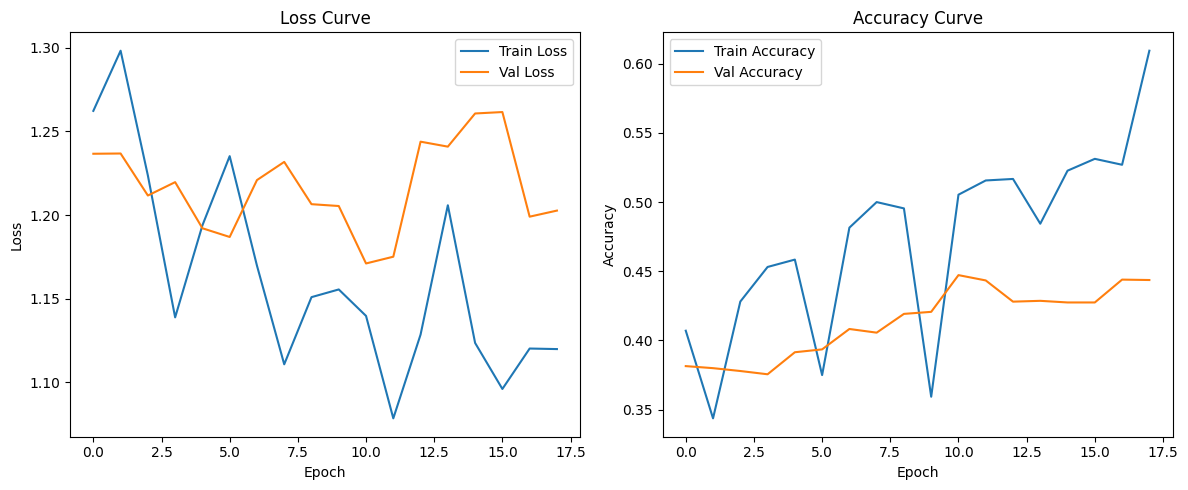

In [ ]:
# 학습 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## v2 결과 두번째로 얘가 성능 나음


In [ ]:
# 5) 학습
history2 = model_v2.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_steps=val_gen.samples   // val_gen.batch_size,
    callbacks=[earlystop, reduce_lr]
)

Epoch 1/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 76s 142ms/step - accuracy: 0.4426 - loss: 1.2278 - val_accuracy: 0.4909 - val_loss: 1.2236 - learning_rate: 1.0000e-04
Epoch 2/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5781 - loss: 1.0254 - val_accuracy: 0.4935 - val_loss: 1.2218 - learning_rate: 1.0000e-04
Epoch 3/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 66s 133ms/step - accuracy: 0.5572 - loss: 1.0713 - val_accuracy: 0.5015 - val_loss: 1.1166 - learning_rate: 1.0000e-04
Epoch 4/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5469 - loss: 1.1110 - val_accuracy: 0.5015 - val_loss: 1.1181 - learning_rate: 1.0000e-04
Epoch 5/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 67s 134ms/step - accuracy: 0.5933 - loss: 0.9967 - val_accuracy: 0.5271 - val_loss: 1.1085 - learning_rate: 1.0000e-04
Epoch 6/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5156 - loss: 1.0253 - val_accuracy: 0.5254 - val_loss: 1.1096 - learning_rate: 1.0000e-04
Epoch 7/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 67s 135ms/st

In [ ]:
import numpy as np

# 1) 최고 Validation Accuracy 구하기
best_val_acc = max(history2.history['val_accuracy'])
# 2) 최고 성능일 때의 에폭(1-indexed)
best_epoch = history2.history['val_accuracy'].index(best_val_acc) + 1

# 3) 최종 Train Accuracy
final_train_acc = history2.history['accuracy'][-1]
# 4) 최종 Validation Accuracy
final_val_acc = history2.history['val_accuracy'][-1]

print(f"최고 Validation Accuracy: {best_val_acc:.4f}")
print(f"Epoch (최고 성능 시점): {best_epoch}")
print(f"최종 Train Accuracy: {final_train_acc:.4f}")
print(f"최종 Validation Accuracy: {final_val_acc:.4f}")


최고 Validation Accuracy: 0.6156
Epoch (최고 성능 시점): 26
최종 Train Accuracy: 0.7812
최종 Validation Accuracy: 0.6035


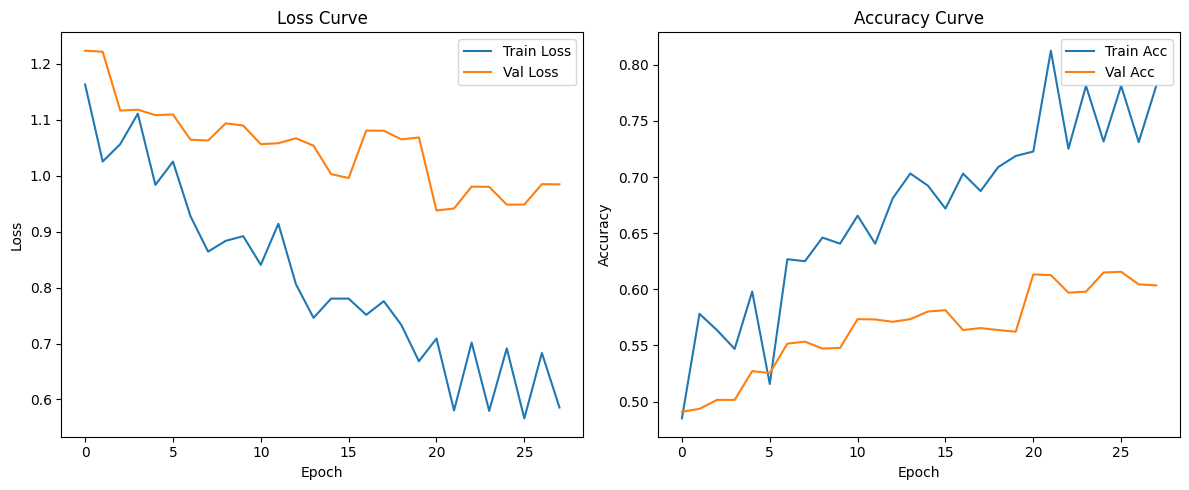

In [ ]:
import matplotlib.pyplot as plt

# 1) Figure 크기 설정
plt.figure(figsize=(12, 5))

# 2) Loss 곡선
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'],     label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3) Accuracy 곡선
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'],     label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## V3 결과

In [ ]:
# 5) 학습
history3 = model_v3.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_steps=val_gen.samples   // val_gen.batch_size,
    callbacks=[earlystop, reduce_lr]
)

Epoch 1/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - accuracy: 0.3849 - loss: 1.3440 - val_accuracy: 0.2957 - val_loss: 1.3492 - learning_rate: 1.0000e-04
Epoch 2/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4844 - loss: 1.1529 - val_accuracy: 0.2998 - val_loss: 1.3477 - learning_rate: 1.0000e-04
Epoch 3/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 67s 134ms/step - accuracy: 0.5025 - loss: 1.1526 - val_accuracy: 0.4490 - val_loss: 1.2001 - learning_rate: 1.0000e-04
Epoch 4/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5781 - loss: 1.0693 - val_accuracy: 0.4493 - val_loss: 1.2035 - learning_rate: 1.0000e-04
Epoch 5/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 66s 133ms/step - accuracy: 0.5243 - loss: 1.1090 - val_accuracy: 0.4776 - val_loss: 1.2013 - learning_rate: 1.0000e-04
Epoch 6/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6094 - loss: 1.0201 - val_accuracy: 0.4791 - val_loss: 1.1970 - learning_rate: 1.0000e-04
Epoch 7/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 67s 134ms/st

In [ ]:
import numpy as np

# 1) 최고 Validation Accuracy 구하기
best_val_acc = max(history3.history['val_accuracy'])
# 2) 최고 성능일 때의 에폭(1-indexed)
best_epoch = history3.history['val_accuracy'].index(best_val_acc) + 1

# 3) 최종 Train Accuracy
final_train_acc = history3.history['accuracy'][-1]
# 4) 최종 Validation Accuracy
final_val_acc = history3.history['val_accuracy'][-1]

print(f"최고 Validation Accuracy: {best_val_acc:.4f}")
print(f"Epoch (최고 성능 시점): {best_epoch}")
print(f"최종 Train Accuracy: {final_train_acc:.4f}")
print(f"최종 Validation Accuracy: {final_val_acc:.4f}")


최고 Validation Accuracy: 0.5318
Epoch (최고 성능 시점): 15
최종 Train Accuracy: 0.5973
최종 Validation Accuracy: 0.5186


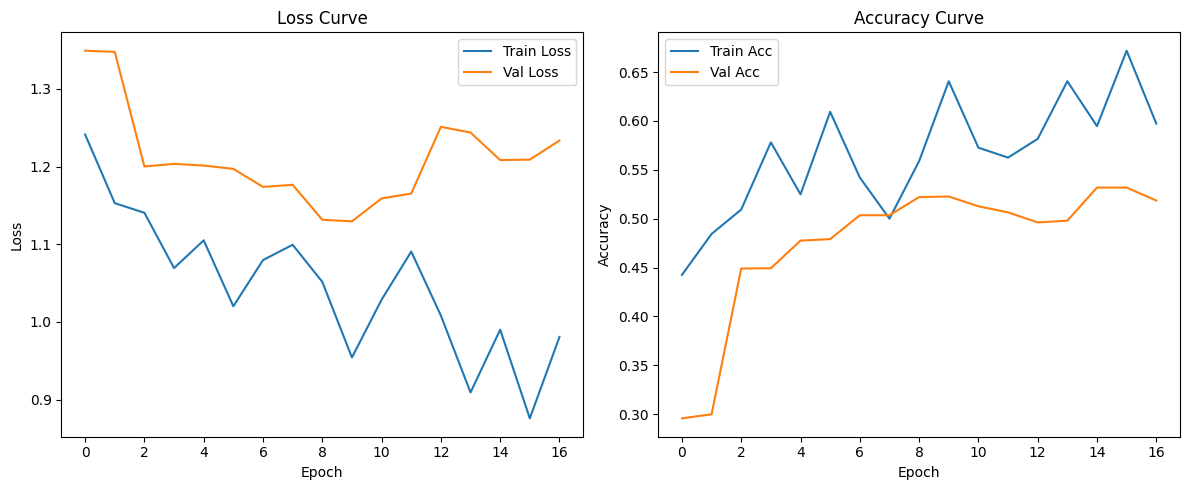

In [ ]:
import matplotlib.pyplot as plt

# 1) Figure 크기 설정
plt.figure(figsize=(12, 5))

# 2) Loss 곡선
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'],     label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3) Accuracy 곡선
plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'],     label='Train Acc')
plt.plot(history3.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## V4결과

In [ ]:
# 5) 학습
history4 = model_v4.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_steps=val_gen.samples   // val_gen.batch_size,
    callbacks=[earlystop, reduce_lr]
)

Epoch 1/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 74s 139ms/step - accuracy: 0.4004 - loss: 1.3397 - val_accuracy: 0.3989 - val_loss: 1.2833 - learning_rate: 1.0000e-04
Epoch 2/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4844 - loss: 1.2187 - val_accuracy: 0.3986 - val_loss: 1.2832 - learning_rate: 1.0000e-04
Epoch 3/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 66s 133ms/step - accuracy: 0.4108 - loss: 1.2638 - val_accuracy: 0.4148 - val_loss: 1.2558 - learning_rate: 1.0000e-04
Epoch 4/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3906 - loss: 1.2191 - val_accuracy: 0.4148 - val_loss: 1.2561 - learning_rate: 1.0000e-04
Epoch 5/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 66s 133ms/step - accuracy: 0.4229 - loss: 1.2321 - val_accuracy: 0.4177 - val_loss: 1.2350 - learning_rate: 1.0000e-04
Epoch 6/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4375 - loss: 1.2145 - val_accuracy: 0.4204 - val_loss: 1.2357 - learning_rate: 1.0000e-04
Epoch 7/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 67s 134ms/st

In [ ]:
import numpy as np

# 1) 최고 Validation Accuracy 구하기
best_val_acc = max(history4.history['val_accuracy'])
# 2) 최고 성능일 때의 에폭(1-indexed)
best_epoch = history4.history['val_accuracy'].index(best_val_acc) + 1

# 3) 최종 Train Accuracy
final_train_acc = history4.history['accuracy'][-1]
# 4) 최종 Validation Accuracy
final_val_acc = history4.history['val_accuracy'][-1]

print(f"최고 Validation Accuracy: {best_val_acc:.4f}")
print(f"Epoch (최고 성능 시점): {best_epoch}")
print(f"최종 Train Accuracy: {final_train_acc:.4f}")
print(f"최종 Validation Accuracy: {final_val_acc:.4f}")


최고 Validation Accuracy: 0.4649
Epoch (최고 성능 시점): 7
최종 Train Accuracy: 0.5150
최종 Validation Accuracy: 0.4608


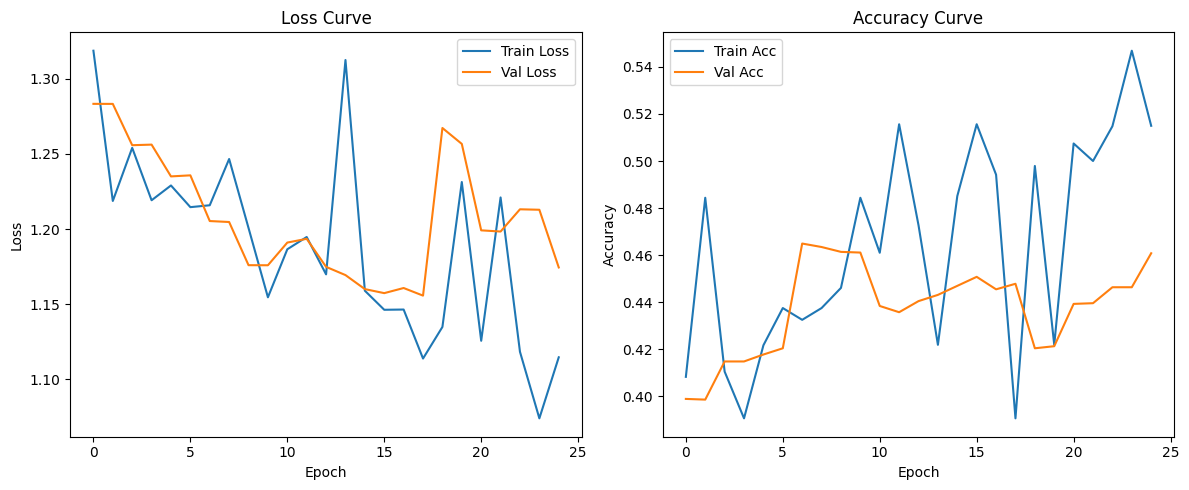

In [ ]:
import matplotlib.pyplot as plt

# 1) Figure 크기 설정
plt.figure(figsize=(12, 5))

# 2) Loss 곡선
plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'],     label='Train Loss')
plt.plot(history4.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3) Accuracy 곡선
plt.subplot(1, 2, 2)
plt.plot(history4.history['accuracy'],     label='Train Acc')
plt.plot(history4.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


##V5 결과

In [ ]:
# 학습 호출 예시
history5 = model_v5.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_steps=val_gen.samples // val_gen.batch_size,
    callbacks=[earlystop, reduce_lr]
)

Epoch 1/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 83s 149ms/step - accuracy: 0.5606 - loss: 1.0528 - val_accuracy: 0.3096 - val_loss: 2.3029 - learning_rate: 0.0010
Epoch 2/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7344 - loss: 0.7042 - val_accuracy: 0.3146 - val_loss: 2.2890 - learning_rate: 0.0010
Epoch 3/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 67s 134ms/step - accuracy: 0.7015 - loss: 0.7374 - val_accuracy: 0.4785 - val_loss: 2.6174 - learning_rate: 0.0010
Epoch 4/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7656 - loss: 0.5405 - val_accuracy: 0.4800 - val_loss: 2.6646 - learning_rate: 0.0010
Epoch 5/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 67s 134ms/step - accuracy: 0.7469 - loss: 0.6314 - val_accuracy: 0.4472 - val_loss: 2.6084 - learning_rate: 0.0010
Epoch 6/50
  1/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8281 - loss: 0.4800
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8281 - los

In [ ]:
import numpy as np

# 1) 최고 Validation Accuracy 구하기
best_val_acc = max(history5.history['val_accuracy'])
# 2) 최고 성능일 때의 에폭(1-indexed)
best_epoch = history5.history['val_accuracy'].index(best_val_acc) + 1

# 3) 최종 Train Accuracy
final_train_acc = history5.history['accuracy'][-1]
# 4) 최종 Validation Accuracy
final_val_acc = history5.history['val_accuracy'][-1]

print(f"최고 Validation Accuracy: {best_val_acc:.4f}")
print(f"Epoch (최고 성능 시점): {best_epoch}")
print(f"최종 Train Accuracy: {final_train_acc:.4f}")
print(f"최종 Validation Accuracy: {final_val_acc:.4f}")


최고 Validation Accuracy: 0.6648
Epoch (최고 성능 시점): 10
최종 Train Accuracy: 0.8437
최종 Validation Accuracy: 0.6135


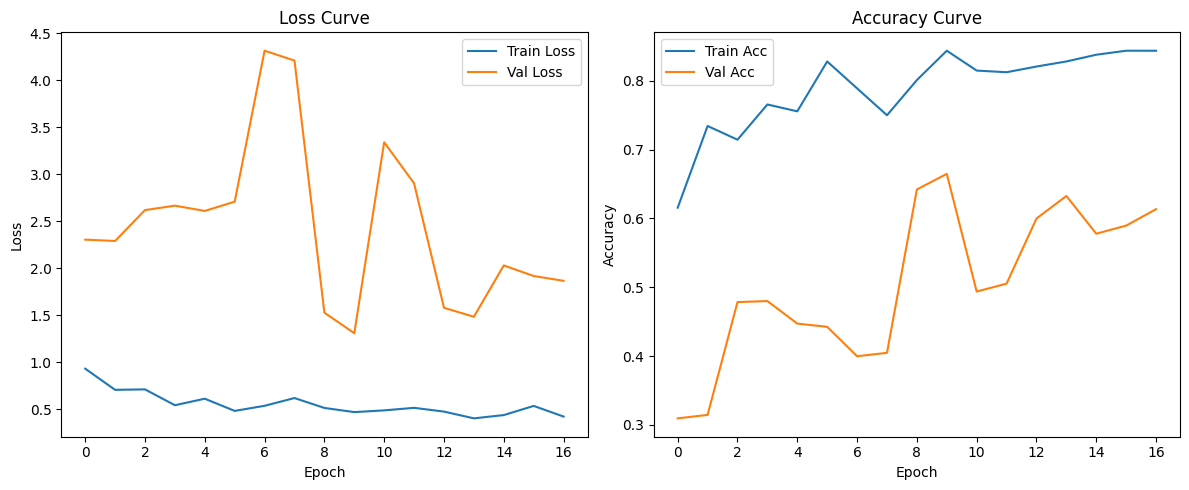

In [ ]:
import matplotlib.pyplot as plt

# 1) Figure 크기 설정
plt.figure(figsize=(12, 5))

# 2) Loss 곡선
plt.subplot(1, 2, 1)
plt.plot(history5.history['loss'],     label='Train Loss')
plt.plot(history5.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3) Accuracy 곡선
plt.subplot(1, 2, 2)
plt.plot(history5.history['accuracy'],     label='Train Acc')
plt.plot(history5.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


##V6결과 -> 이게 성능 제일 나음

In [ ]:
# 학습 호출 예시
history6 = model_v6.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_steps=val_gen.samples // val_gen.batch_size,
    callbacks=[earlystop, reduce_lr]
)

Epoch 1/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 84s 150ms/step - accuracy: 0.6095 - loss: 0.9881 - val_accuracy: 0.4204 - val_loss: 2.5489 - learning_rate: 0.0010
Epoch 2/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8125 - loss: 0.6182 - val_accuracy: 0.4346 - val_loss: 2.8823 - learning_rate: 0.0010
Epoch 3/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 66s 133ms/step - accuracy: 0.7593 - loss: 0.6540 - val_accuracy: 0.6209 - val_loss: 1.4363 - learning_rate: 0.0010
Epoch 4/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7344 - loss: 0.5810 - val_accuracy: 0.6619 - val_loss: 1.3427 - learning_rate: 0.0010
Epoch 5/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 67s 134ms/step - accuracy: 0.8109 - loss: 0.5373 - val_accuracy: 0.6919 - val_loss: 0.8412 - learning_rate: 0.0010
Epoch 6/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7500 - loss: 0.6162 - val_accuracy: 0.6586 - val_loss: 0.9676 - learning_rate: 0.0010
Epoch 7/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 66s 133ms/step - accuracy: 0.8344 - 

In [ ]:
import numpy as np

# 1) 최고 Validation Accuracy 구하기
best_val_acc = max(history6.history['val_accuracy'])
# 2) 최고 성능일 때의 에폭(1-indexed)
best_epoch = history6.history['val_accuracy'].index(best_val_acc) + 1

# 3) 최종 Train Accuracy
final_train_acc = history6.history['accuracy'][-1]
# 4) 최종 Validation Accuracy
final_val_acc = history6.history['val_accuracy'][-1]

print(f"최고 Validation Accuracy: {best_val_acc:.4f}")
print(f"Epoch (최고 성능 시점): {best_epoch}")
print(f"최종 Train Accuracy: {final_train_acc:.4f}")
print(f"최종 Validation Accuracy: {final_val_acc:.4f}")


최고 Validation Accuracy: 0.7919
Epoch (최고 성능 시점): 11
최종 Train Accuracy: 0.9375
최종 Validation Accuracy: 0.7686


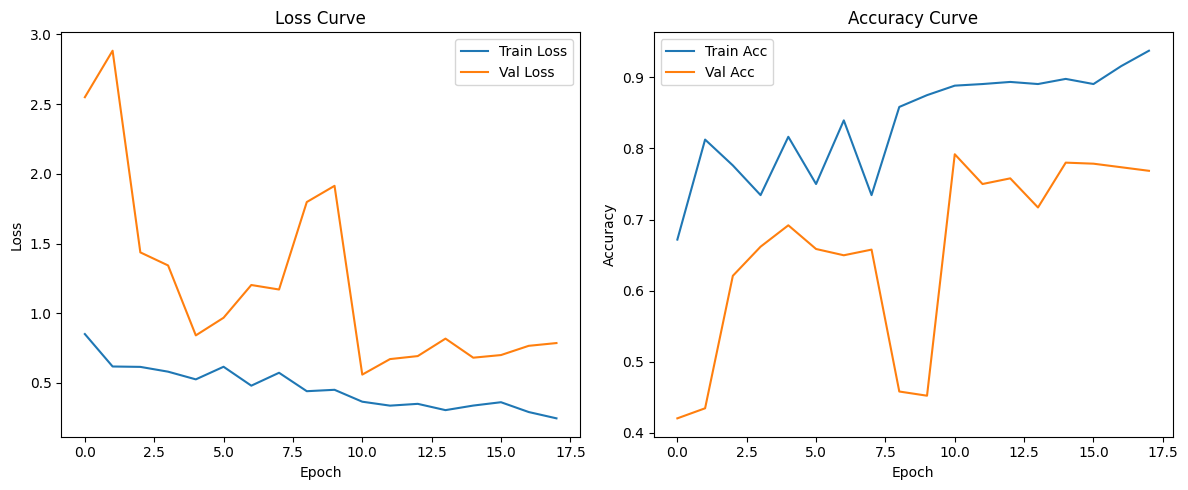

In [ ]:
import matplotlib.pyplot as plt

# 1) Figure 크기 설정
plt.figure(figsize=(12, 5))

# 2) Loss 곡선
plt.subplot(1, 2, 1)
plt.plot(history6.history['loss'],     label='Train Loss')
plt.plot(history6.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3) Accuracy 곡선
plt.subplot(1, 2, 2)
plt.plot(history6.history['accuracy'],     label='Train Acc')
plt.plot(history6.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


##V7 결과

In [ ]:
# 학습 호출 예시
history7 = model_v7.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_steps=val_gen.samples // val_gen.batch_size,
    callbacks=[earlystop, reduce_lr]
)

Epoch 1/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 81s 144ms/step - accuracy: 0.4545 - loss: 1.2275 - val_accuracy: 0.2426 - val_loss: 1.6811 - learning_rate: 1.0000e-04
Epoch 2/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6094 - loss: 1.0558 - val_accuracy: 0.2426 - val_loss: 1.6829 - learning_rate: 1.0000e-04
Epoch 3/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 67s 134ms/step - accuracy: 0.5662 - loss: 1.0418 - val_accuracy: 0.3034 - val_loss: 1.8744 - learning_rate: 1.0000e-04
Epoch 4/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5625 - loss: 0.9614 - val_accuracy: 0.3075 - val_loss: 1.8407 - learning_rate: 1.0000e-04
Epoch 5/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6095 - loss: 0.9541
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
498/498 ━━━━━━━━━━━━━━━━━━━━ 67s 134ms/step - accuracy: 0.6095 - loss: 0.9541 - val_accuracy: 0.2972 - val_loss: 2.0801 - learning_rate: 1.0000e-04
Epoch 6/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - a

In [ ]:
import numpy as np

# 1) 최고 Validation Accuracy 구하기
best_val_acc = max(history7.history['val_accuracy'])
# 2) 최고 성능일 때의 에폭(1-indexed)
best_epoch = history7.history['val_accuracy'].index(best_val_acc) + 1

# 3) 최종 Train Accuracy
final_train_acc = history7.history['accuracy'][-1]
# 4) 최종 Validation Accuracy
final_val_acc = history7.history['val_accuracy'][-1]

print(f"최고 Validation Accuracy: {best_val_acc:.4f}")
print(f"Epoch (최고 성능 시점): {best_epoch}")
print(f"최종 Train Accuracy: {final_train_acc:.4f}")
print(f"최종 Validation Accuracy: {final_val_acc:.4f}")


최고 Validation Accuracy: 0.3075
Epoch (최고 성능 시점): 4
최종 Train Accuracy: 0.5781
최종 Validation Accuracy: 0.2786


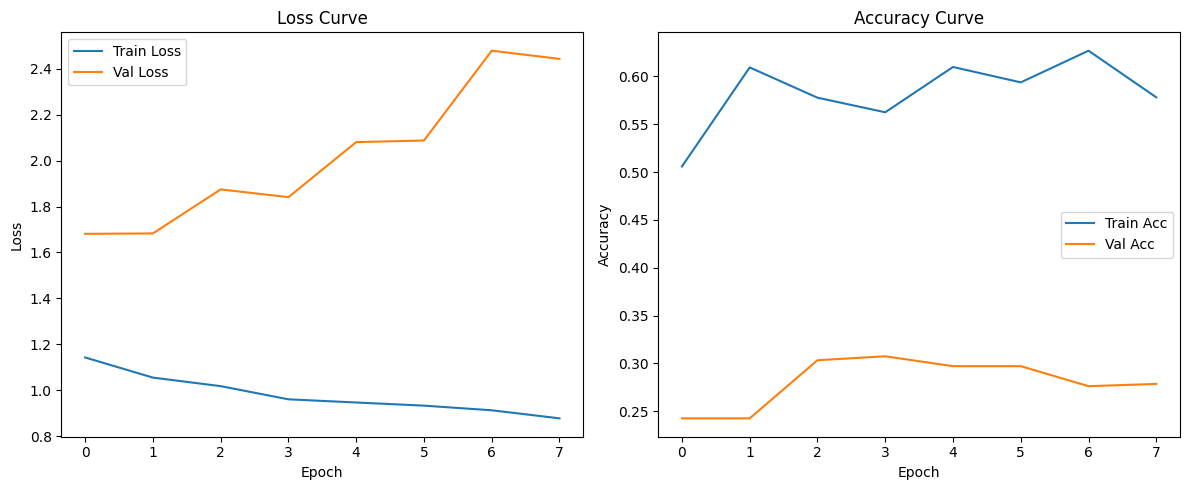

In [ ]:
import matplotlib.pyplot as plt

# 1) Figure 크기 설정
plt.figure(figsize=(12, 5))

# 2) Loss 곡선
plt.subplot(1, 2, 1)
plt.plot(history7.history['loss'],     label='Train Loss')
plt.plot(history7.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3) Accuracy 곡선
plt.subplot(1, 2, 2)
plt.plot(history7.history['accuracy'],     label='Train Acc')
plt.plot(history7.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#CNN 성능 향상

##V6-1

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --------------------------------------------------------
# 2) 모델 정의: GaussianNoise 레이어만 추가
# --------------------------------------------------------
model_v6_1 = models.Sequential([
    layers.Input(shape=(128, 128, 1)),  # 1채널 입력
    layers.GaussianNoise(0.05),         # Gaussian noise 추가

    # Block 1
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    # Block 2
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    # Block 3
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    # Classification Head
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])

model_v6_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_v6_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 305,252 (1.16 MB)

 Trainable params: 304,356 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
history6_1 = model_v6_1.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    epochs=50,
    validation_data=val_gen,
    validation_steps=val_gen.samples // val_gen.batch_size,
    callbacks=[earlystop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5602s 11s/step - accuracy: 0.6158 - loss: 0.9349 - val_accuracy: 0.4083 - val_loss: 27.8071 - learning_rate: 0.0010
Epoch 2/50
  1/498 ━━━━━━━━━━━━━━━━━━━━ 1:33:24 11s/step - accuracy: 0.8125 - loss: 0.6385

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


498/498 ━━━━━━━━━━━━━━━━━━━━ 141s 262ms/step - accuracy: 0.8125 - loss: 0.6385 - val_accuracy: 0.4057 - val_loss: 27.7809 - learning_rate: 0.0010
Epoch 3/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5478s 11s/step - accuracy: 0.7879 - loss: 0.5392 - val_accuracy: 0.5195 - val_loss: 2.1068 - learning_rate: 0.0010
Epoch 4/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 143s 265ms/step - accuracy: 0.8125 - loss: 0.5348 - val_accuracy: 0.4838 - val_loss: 2.5751 - learning_rate: 0.0010
Epoch 5/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5600s 11s/step - accuracy: 0.8613 - loss: 0.3708 - val_accuracy: 0.3794 - val_loss: 3.5790 - learning_rate: 0.0010
Epoch 6/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 158s 296ms/step - accuracy: 0.9844 - loss: 0.1080 - val_accuracy: 0.3903 - val_loss: 3.5822 - learning_rate: 0.0010
Epoch 7/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 5586s 11s/step - accuracy: 0.8905 - loss: 0.3038 - val_accuracy: 0.5943 - val_loss: 1.5749 - learning_rate: 0.0010
Epoch 8/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 140s 262ms/step - accuracy: 0.8281 - 

In [ ]:
import numpy as np

# 1) 최고 Validation Accuracy 구하기
best_val_acc = max(history6_1.history['val_accuracy'])
# 2) 최고 성능일 때의 에폭(1-indexed)
best_epoch = history6_1.history['val_accuracy'].index(best_val_acc) + 1

# 3) 최종 Train Accuracy
final_train_acc = history6_1.history['accuracy'][-1]
# 4) 최종 Validation Accuracy
final_val_acc = history6_1.history['val_accuracy'][-1]

print(f"최고 Validation Accuracy: {best_val_acc:.4f}")
print(f"Epoch (최고 성능 시점): {best_epoch}")
print(f"최종 Train Accuracy: {final_train_acc:.4f}")
print(f"최종 Validation Accuracy: {final_val_acc:.4f}")


In [ ]:
import matplotlib.pyplot as plt

# 1) Figure 크기 설정
plt.figure(figsize=(12, 5))

# 2) Loss 곡선
plt.subplot(1, 2, 1)
plt.plot(history6.history['loss'],     label='Train Loss')
plt.plot(history6.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3) Accuracy 곡선
plt.subplot(1, 2, 2)
plt.plot(history6.history['accuracy'],     label='Train Acc')
plt.plot(history6.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## V6-2

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# --------------------------------------------------------
# 2) 모델 정의: Dropout 비율 및 L2 Regularizer 강화
# --------------------------------------------------------
model_v6_2 = models.Sequential([
    layers.Input(shape=(128, 128, 1)),
    layers.GaussianNoise(0.05),

    # Block 1: Conv2D에 L2=1e-3, Dropout=0.3
    layers.Conv2D(32, (3,3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # Block 2: Conv2D에 L2=1e-3, Dropout=0.3
    layers.Conv2D(64, (3,3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # Block 3: Conv2D에 L2=1e-3, Dropout=0.3
    layers.Conv2D(128, (3,3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # Classification Head: Dense에 L2=1e-3, Dropout=0.4
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

model_v6_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history6_2 = model_v6_2.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    epochs=50,
    validation_data=val_gen,
    validation_steps=val_gen.samples // val_gen.batch_size,
    callbacks=[earlystop, reduce_lr]
)